In [2]:
# numbers_generator.py
import os
import numpy as np
import random
from PIL import Image, ImageOps, ImageChops
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import time
import matplotlib.pyplot as plt

class HandwrittenNumbersDataset(Dataset):
    digits_per_class = 5000

    def __init__(self, custom_dataset_folder, mnist_dataset, max_digits=5, length=100_000, include_leading_zeros=False, seed=None, pre_generate=False, num_threads=1):
        self.custom_dataset_folder = custom_dataset_folder
        self.mnist_dataset = mnist_dataset
        self.max_digits = max_digits
        self.include_leading_zeros = include_leading_zeros
        self.seed = seed
        self.pre_generate = pre_generate
        self.num_threads = num_threads
        self.length = length

        # Load digit images
        self.digit_images = self.load_digit_images()

        # Set seed for reproducibility
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        # Pre-generate data if required
        if self.pre_generate:
            start_time = time.time()
            self.data = []
            self.generate_data_single_threaded()
            end_time = time.time()
            print(f"Data generation time: {end_time - start_time:.2f} seconds")

    def load_digit_images(self):
        # Load images from custom dataset and MNIST
        digit_images = {str(i): [] for i in range(10)}
        custom_counts = {}

        # Load custom dataset images
        for digit in range(10):
            folder_path = os.path.join(self.custom_dataset_folder, str(digit))
            if os.path.exists(folder_path):
                images = []
                for img_file in os.listdir(folder_path):
                    if img_file.endswith('.png'):
                        img_path = os.path.join(folder_path, img_file)
                        image = Image.open(img_path).convert('L')  # Grayscale
                        # Invert image if necessary
                        if np.mean(image) > 127:
                            image = ImageOps.invert(image)
                        images.append(image)
                print(f"use {folder_path}, load {len(images)} images")
                digit_images[str(digit)].extend(images)
                custom_counts[str(digit)] = len(images)
            else:
                custom_counts[str(digit)] = 0

        # Limit MNIST usage to complement up to 1000 digits per class
        mnist_digit_counts = {str(i): 0 for i in range(10)}
        mnist_digit_images = {str(i): [] for i in range(10)}
        for img, label in self.mnist_dataset:
            label_str = str(label)
            if mnist_digit_counts[label_str] < self.digits_per_class - custom_counts[label_str]:
                # Invert MNIST images if necessary
                if np.mean(img) > 127:
                    img = ImageOps.invert(img)
                mnist_digit_images[label_str].append(img)
                mnist_digit_counts[label_str] += 1
            if all(count >= self.digits_per_class - custom_counts[str(i)] for i, count in mnist_digit_counts.items()):
                break

        # Combine custom and MNIST images
        for digit in digit_images.keys():
            digit_images[digit].extend(mnist_digit_images[digit])

        return digit_images

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.pre_generate:
            return self.data[idx]
        else:
            return self.generate_sample()

    def generate_sample(self):
        # Generate a random number
        num_digits = random.randint(1, self.max_digits)
        if self.include_leading_zeros and random.random() < 0.1:
            # 10% chance to include leading zeros
            number_str = ''.join([str(random.randint(0, 9)) for _ in range(num_digits)])
            number_str = number_str.zfill(self.max_digits)
        else:
            number = random.randint(0, 10**num_digits - 1)
            number_str = str(number).zfill(num_digits)

        # Build the image by concatenating digit images with random spacing and vertical position
        digit_images = []
        for digit_char in number_str:
            digit_image = random.choice(self.digit_images[digit_char])
            digit_image = self.augment_digit(digit_image)
            digit_images.append(digit_image)

        composite_image = self.concatenate_digits(digit_images)
        processed_image = self.process_image(composite_image)

        # Convert image to tensor
        image_tensor = transforms.ToTensor()(processed_image)

        # Prepare the label
        label = number_str  # Now label is a string

        return image_tensor, label

    def augment_digit(self, image):
        # Data augmentation transformations
        transform_list = []

        # Random rotation
        rotation_degree = random.uniform(-10, 10)
        image = image.rotate(rotation_degree, fillcolor=0)

        # Random zoom
        scale_factor = random.uniform(0.9, 1.1)
        new_size = (int(image.size[0]*scale_factor), int(image.size[1]*scale_factor))
        image = image.resize(new_size, Image.LANCZOS)

        # Random shift
        max_dx = 4
        max_dy = 4
        dx = random.randint(-max_dx, max_dx)
        dy = random.randint(-max_dy, max_dy)
        image = ImageChops.offset(image, dx, dy)

        return image

    def concatenate_digits(self, digit_images):
        # Random vertical shifts and spacing
        max_digit_height = max(img.size[1] for img in digit_images)
        vertical_shifts = [random.randint(-5, 5) for _ in digit_images]
        spacings = [random.randint(-12, 10) for _ in range(len(digit_images)-1)]

        # Calculate total width
        total_width = sum(img.size[0] for img in digit_images) + sum(spacings)
        canvas_height = max_digit_height + 10  # Extra space for vertical shifts

        new_image = Image.new('L', (total_width, canvas_height), color=0)  # Black background

        x_offset = 0
        for i, im in enumerate(digit_images):
            y_offset = (canvas_height - im.size[1]) // 2 + vertical_shifts[i]
            temp_image = Image.new('L', new_image.size, color=0)
            temp_image.paste(im, (x_offset, y_offset))
            new_image = ImageChops.lighter(new_image, temp_image)

            if i < len(spacings):
                x_offset += im.size[0] + spacings[i]
            else:
                x_offset += im.size[0]

        return new_image

    def process_image(self, image):
        # Scale image so that the maximum height of the content is 30 pixels
        max_content_height = 30
        w_percent = (max_content_height / float(image.size[1]))
        new_width = int((float(image.size[0]) * float(w_percent)))
        image = image.resize((new_width, max_content_height), Image.LANCZOS)

        # Add 1-pixel margins to make height 32 pixels
        image = ImageOps.expand(image, border=(0, 1), fill=0)  # Black background

        # Right-align and crop or pad if necessary
        if image.size[0] > 128:
            image = image.crop((image.size[0] - 128, 0, image.size[0], image.size[1]))
        else:
            # Add padding to the left
            padding = 128 - image.size[0]
            image = ImageOps.expand(image, border=(padding, 0, 0, 0), fill=0)  # Black background

        return image

    def visualize_sample(self, idx=None):
        if idx is None:
            image_tensor, label = self.generate_sample()
        else:
            image_tensor, label = self[idx]
        image = transforms.ToPILImage()(image_tensor)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

    def generate_data_single_threaded(self):
        data_length = self.__len__()
        self.data = []

        for i in range(data_length):
            self.data.append(self.generate_sample())

        # Shuffle the data
        random.shuffle(self.data)


from torchvision.datasets import MNIST



def test_dataset():
    # Load MNIST dataset
    mnist_dataset = MNIST(root='./data', train=True, download=True)

    length=100_000
    seed = random.randint(0, 9999999)
    # seed = 2122224
    print(f"Seed: {seed}")
    # Create the custom dataset
    dataset = HandwrittenNumbersDataset(
        custom_dataset_folder='/Users/sergejsorin/work/math/lib/mnist_improve/local_data/sorted',
        mnist_dataset=mnist_dataset,
        max_digits=5,
        length=length,
        include_leading_zeros=True,
        seed=seed,  # For reproducibility
        pre_generate=True  # Set to True to pre-generate data
    )

    # Visualize a sample for debugging
    # dataset.visualize_sample()

    dataset.generate_sample()
    # # Measure dataset generation speed
    # start_time = time.time()
    # for _ in range(100):
    #     dataset.generate_sample()
    # end_time = time.time()
    # print(f"Time to generate 100 samples: {end_time - start_time:.2f} seconds")

    # # Use DataLoader for batching
    # data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
    import os
    import hashlib
    from PIL import Image
    import io

    def image_to_hash(image):
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='PNG')
        return hashlib.md5(img_byte_arr.getvalue()).hexdigest()

    def check_and_save_images(dataset, num_images=100000, save_interval=1000):
        os.makedirs('raw_images', exist_ok=True)
        os.makedirs('raw_duplicates', exist_ok=True)
        image_hashes = {}
        duplicate_count = 0

        for i in range(num_images):
            image_tensor, label = dataset[i]
            image = transforms.ToPILImage()(image_tensor)
            
            image_hash = image_to_hash(image)
            number = ''.join(map(str, label.numpy()))
            
            if image_hash in image_hashes:
                duplicate_count += 1
                # Save duplicate
                dup_filename = f"raw_duplicates/{image_hash}_{number}_dup{duplicate_count}.png"
                image.save(dup_filename)
                # Save original for comparison
                orig_filename = f"raw_duplicates/{image_hash}_{number}_orig.png"
                orig_image, _ = dataset[image_hashes[image_hash]]
                orig_image = transforms.ToPILImage()(orig_image)
                orig_image.save(orig_filename)
            else:
                image_hashes[image_hash] = i
                if i % save_interval == 0:
                    filename = f"raw_images/{image_hash}_{number}.png"
                    image.save(filename)
            
            if i % 1000 == 0:
                print(f"Processed {i} images. Duplicates so far: {duplicate_count}")

        print(f"Total images processed: {num_images}")
        print(f"Total unique images: {len(image_hashes)}")
        print(f"Total duplicates: {duplicate_count}")

    # Run the check
    check_and_save_images(dataset, length)

is_in_cloud = torch.cuda.is_available()
if __name__ == "__main__":
    if not is_in_cloud:
        test_dataset()



In [73]:
# main.py

DATASET_SIZE = 120_000
TEST_DATASET_SIZE = 3_000
BATCH_SIZE = 64
NUM_EPOCH = 75

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import itertools
from torchvision.datasets import MNIST
from torchvision import transforms

import torch.nn.functional as F

# class CRNN(nn.Module):
#     def __init__(self, imgH=32, nc=1, nclass=12, nh=256, n_rnn=2, leakyRelu=False):
#         super(CRNN, self).__init__()
#         assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

#         ks = [3, 3, 3, 3, 3, 3, 2]
#         ps = [1, 1, 1, 1, 1, 1, 0]
#         ss = [1, 1, 1, 1, 1, 1, 1]
#         nm = [64, 128, 256, 256, 512, 512, 512]

#         cnn = nn.Sequential()

#         def convRelu(i, batchNormalization=False):
#             nIn = nc if i == 0 else nm[i - 1]
#             nOut = nm[i]
#             cnn.add_module('conv{0}'.format(i),
#                            nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
#             if batchNormalization:
#                 cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
#             if leakyRelu:
#                 cnn.add_module('relu{0}'.format(i),
#                                nn.LeakyReLU(0.2, inplace=True))
#             else:
#                 cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

#         convRelu(0)
#         cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
#         convRelu(1)
#         cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
#         convRelu(2, True)
#         convRelu(3)
#         cnn.add_module('pooling{0}'.format(2),
#                        nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
#         convRelu(4, True)
#         convRelu(5)
#         cnn.add_module('pooling{0}'.format(3),
#                        nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
#         convRelu(6, True)  # 512x1x16

#         self.cnn = cnn
#         self.rnn = nn.Sequential(
#             BidirectionalLSTM(nm[-1], nh, nh),
#             BidirectionalLSTM(nh, nh, nclass))

#     def forward(self, input):
#         # conv features
#         conv = self.cnn(input)
#         b, c, h, w = conv.size()
#         # assert h == 1, "the height of conv must be 1"
#         conv = conv.squeeze(2)
#         conv = conv.permute(2, 0, 1)  # [w, b, c]

#         # rnn features
#         output = self.rnn(conv)

#         # add log_softmax to converge output
#         output = F.log_softmax(output, dim=2)

#         return output

class CRNN(nn.Module):
    def __init__(self, imgH=32, nc=1, nclass=12, nh=128, n_rnn=1, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [32, 64, 128, 128, 256, 256, 256]  # Уменьшенные количества каналов

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(6, True)

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(nm[-1], nh, nclass))  # Уменьшено количество рекуррентных слоёв

    def forward(self, input):
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        output = self.rnn(conv)
        output = F.log_softmax(output, dim=2)
        return output


class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output


# Константы
CTC_BLANK = '<BLANK>'
OOV_TOKEN = '<OOV>'

class Tokenizer:
    def __init__(self, alphabet):
        self.char_map = {CTC_BLANK: 0, OOV_TOKEN: 1}
        for i, char in enumerate(alphabet):
            self.char_map[char] = i + 2
        self.rev_char_map = {v: k for k, v in self.char_map.items()}

    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append([self.char_map.get(char, self.char_map[OOV_TOKEN]) for char in word])
        return enc_words

    def decode(self, enc_word_list, merge_repeated=True):
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            prev_char = None
            for char_enc in word:
                char = self.rev_char_map.get(char_enc, OOV_TOKEN)
                if char != CTC_BLANK and char != OOV_TOKEN:
                    if not (merge_repeated and char == prev_char):
                        word_chars += char
                prev_char = char
            dec_words.append(word_chars)
        return dec_words


# Вспомогательные функции
def train(model, criterion, optimizer, train_loader, device, tokenizer):
    model.train()
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        # print("Output shape:", output.shape)  # Проверка размерности выхода модели

        target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long)
        targets = torch.cat([torch.tensor(t, dtype=torch.long) for t in targets]).to(device)
        input_lengths = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long)

        # print("Target shape:", targets.shape)  # Проверка размерности целевых данных
        # print("Input lengths:", input_lengths)
        # print("Target lengths:", target_lengths)

        loss = criterion(output, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # if batch_idx % 100 == 0:
        #     print(f'Train Batch {batch_idx}, Loss: {loss.item()}')

    return total_loss / len(train_loader)

def evaluate(model, tokenizer, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels_encoded in test_loader:
            data = data.to(device)
            output = model(data)
            output = output.cpu()
            preds = output.argmax(dim=2).transpose(1, 0)
            preds = preds.tolist()
            decoded_preds = tokenizer.decode(preds, merge_repeated=True)
            decoded_labels = tokenizer.decode(labels_encoded, merge_repeated=False)
            for pred, label in zip(decoded_preds, decoded_labels):
                if pred == label:
                    correct += 1
                total += 1
    accuracy = correct / total
    return accuracy


def collate_fn(batch, tokenizer):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    data = torch.stack(data, dim=0)
    labels_encoded = tokenizer.encode(labels)
    # print("Sample encoded label:", labels_encoded[0])  # Проверка закодированной метки
    return data, labels_encoded

def train_model(model, tokenizer):
    is_in_cloud = False
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        is_in_cloud = True
    else:
        device = torch.device("cpu")

    # Определение алфавита и создание токенизатора
    
    model.to(device)

    # Загрузка датасета MNIST
    mnist_train = MNIST(root='./data', train=True, download=True)
    mnist_test = MNIST(root='./data', train=False, download=True)

    # Создание датасетов
    # if not is_in_cloud:
    #     from numbers_generator import HandwrittenNumbersDataset

    custom_dataset_folder = '/Users/sergejsorin/work/math/lib/mnist_improve/local_data/sorted'
    if not os.path.exists(custom_dataset_folder):
        custom_dataset_folder = "/home/user/sorted"

    train_dataset = HandwrittenNumbersDataset(
        custom_dataset_folder=custom_dataset_folder,  # Путь к вашему кастомному датасету, если есть
        mnist_dataset=mnist_train,
        max_digits=5,
        length=DATASET_SIZE,
        include_leading_zeros=False,
        seed=42,
        pre_generate=False,
        num_threads=1
    )

    test_dataset = HandwrittenNumbersDataset(
        custom_dataset_folder='',
        mnist_dataset=mnist_test,
        max_digits=5,
        length=TEST_DATASET_SIZE,
        include_leading_zeros=False,
        seed=43,
        pre_generate=False,
        num_threads=1
    )

    from functools import partial
    collate_fn_with_tokenizer = partial(collate_fn, tokenizer=tokenizer)

    # Создание DataLoader
    batch_size = BATCH_SIZE
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn_with_tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_with_tokenizer)


    # Определение критерия и оптимизатора
    criterion = nn.CTCLoss(blank=tokenizer.char_map[CTC_BLANK], zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Start training")
    print(f"Train params: dataset_size={DATASET_SIZE}, test_dataset_size={TEST_DATASET_SIZE}, batch_size={BATCH_SIZE}, num_epochs={NUM_EPOCH}")

    import time
    # Цикл обучения
    num_epochs = NUM_EPOCH
    for epoch in range(1, num_epochs + 1):
        train_start = time.time()
        train_loss = train(model, criterion, optimizer, train_loader, device, tokenizer)
        train_end = time.time()
        val_accuracy = evaluate(model, tokenizer, test_loader, device)
        train_accuracy = evaluate(model, tokenizer, train_loader, device)
        eval_end = time.time()
        estimated_end_time = train_start + (eval_end - train_start) * (num_epochs - epoch)
        human_readable_eta = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(estimated_end_time))
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Time: {train_end - train_start:.2f}, Eval Time: {eval_end - train_end:.2f}, ETA: {human_readable_eta}')

    # Пример использования модели для предсказания
    model.eval()
    with torch.no_grad():
        # Предположим, у нас есть одно тестовое изображение из тестового датасета
        data_iter = iter(test_loader)
        test_image, test_label = next(data_iter)
        test_image = test_image[0].unsqueeze(0).to(device)
        output = model(test_image)
        pred = output.argmax(dim=2).transpose(1, 0)
        decoded_pred = tokenizer.decode(pred.tolist(), merge_repeated=True)[0]
        print(f"Predicted number: {decoded_pred}")
        print(f"Actual number: {test_label[0]}")
    return model


is_in_cloud = torch.cuda.is_available()
if __name__ == "__main__":
    if not is_in_cloud:
        
        alphabet = "0123456789"
        tokenizer = Tokenizer(alphabet)

        model = CRNN(imgH=32, nc=1, nclass=len(tokenizer.char_map), nh=256, n_rnn=2, leakyRelu=False)

        trained_model = train_model(model, tokenizer)
        os.makedirs('models2', exist_ok=True)
        torch.save(trained_model.state_dict(), 'models2/crnn_model.pth')
        # torch.save(trained_model.state_dict(), 'models/crnn_model.pth')


In [74]:
alphabet = "0123456789"
tokenizer = Tokenizer(alphabet)

model = CRNN(imgH=32, nc=1, nclass=len(tokenizer.char_map), nh=256, n_rnn=2, leakyRelu=False)

trained_model = train_model(model, tokenizer)
os.makedirs('models2', exist_ok=True)
torch.save(trained_model.state_dict(), 'models2/crnn_model.pth')

use /home/user/sorted/0, load 60 images
use /home/user/sorted/1, load 294 images
use /home/user/sorted/2, load 85 images
use /home/user/sorted/3, load 90 images
use /home/user/sorted/4, load 348 images
use /home/user/sorted/5, load 113 images
use /home/user/sorted/6, load 86 images
use /home/user/sorted/7, load 412 images
use /home/user/sorted/8, load 124 images
use /home/user/sorted/9, load 240 images
Start training
Train params: dataset_size=120000, test_dataset_size=3000, batch_size=64, num_epochs=75
Epoch 1, Train Loss: 0.8742, Validation Accuracy: 0.9103, Train Accuracy: 0.8944, Train Time: 23.08, Eval Time: 17.54, ETA: 2024-09-15 16:59:48
Epoch 2, Train Loss: 0.0732, Validation Accuracy: 0.9457, Train Accuracy: 0.9418, Train Time: 23.06, Eval Time: 17.23, ETA: 2024-09-15 16:59:24
Epoch 3, Train Loss: 0.0538, Validation Accuracy: 0.9597, Train Accuracy: 0.9613, Train Time: 23.06, Eval Time: 17.44, ETA: 2024-09-15 16:59:39
Epoch 4, Train Loss: 0.0439, Validation Accuracy: 0.9630, T

In [75]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

def visualize_predictions(model, test_loader, device, tokenizer, num_samples=5):
    model.eval()
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get a batch of test data
            data_iter = iter(test_loader)
            test_images, test_labels = next(data_iter)
            
            # Select the first image from the batch
            test_image = test_images[0].unsqueeze(0).to(device)
            test_label = test_labels[0]

            test_label = [val for pair in zip(test_label, [0]*len(test_label)) for val in pair]
            print(test_label)
            decoded_test_label = tokenizer.decode([test_label], merge_repeated=True)[0]
            
            # Make prediction
            output = model(test_image)
            pred = output.argmax(dim=2).transpose(1, 0)
            decoded_pred = tokenizer.decode(pred.tolist(), merge_repeated=True)[0]
            
            # Convert tensor to image
            image = transforms.ToPILImage()(test_image.squeeze().cpu())
            
            # Display the image and predictions
            plt.figure(figsize=(10, 4))
            plt.imshow(image, cmap='gray')
            plt.title(f"Predicted: {decoded_pred} | Actual: {decoded_test_label}")
            plt.axis('off')
            plt.show()
            
            print(f"Sample {i+1}:")
            print(f"Predicted number: {decoded_pred}")
            print(f"Actual number: {decoded_test_label}")
            if decoded_pred != decoded_test_label:
                print("ERROR")
            print()

mnist_test = MNIST(root='./data', train=False, download=True)
test_dataset = HandwrittenNumbersDataset(
    custom_dataset_folder='',
    mnist_dataset=mnist_test,
    max_digits=5,
    length=TEST_DATASET_SIZE,
    include_leading_zeros=False,
    seed=43,
    pre_generate=False,
    num_threads=1
)

from functools import partial
collate_fn_with_tokenizer = partial(collate_fn, tokenizer=tokenizer)

    # Создание DataLoader
batch_size = BATCH_SIZE
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_with_tokenizer)

[6, 0, 9, 0, 11, 0, 2, 0, 9, 0]


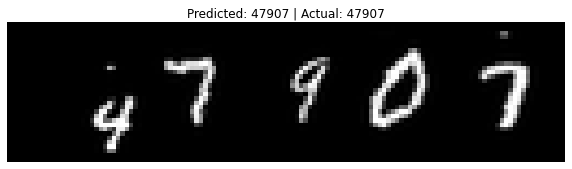

Sample 1:
Predicted number: 47907
Actual number: 47907

[4, 0]


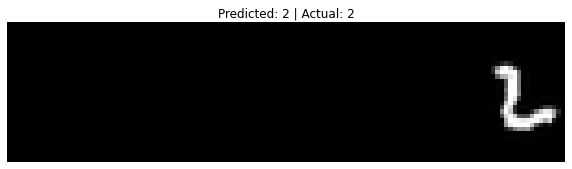

Sample 2:
Predicted number: 2
Actual number: 2

[6, 0]


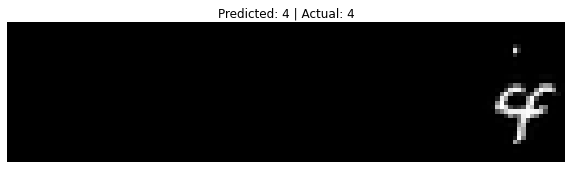

Sample 3:
Predicted number: 4
Actual number: 4

[5, 0]


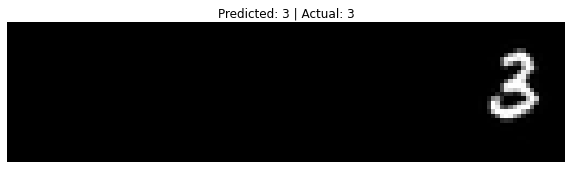

Sample 4:
Predicted number: 3
Actual number: 3

[6, 0, 10, 0, 2, 0]


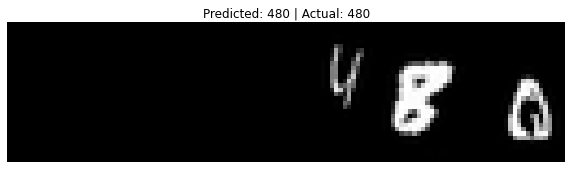

Sample 5:
Predicted number: 480
Actual number: 480



In [76]:
device = torch.device("cuda")
visualize_predictions(model, test_loader, device, tokenizer, 5)

In [63]:
# import torch
# from torch import nn
# import torch.onnx

# # Переводим модель на CPU
# model.cpu()

# # Выполняем динамическую квантизацию
# quantized_model = torch.quantization.quantize_dynamic(
#     model, {nn.Linear, nn.LSTM}, dtype=torch.qint8
# )

# # Создаем пример входных данных
# dummy_input = torch.randn(1, 1, 32, 128)  # Измените размеры по необходимости

# # Экспортируем квантованную модель в формат ONNX
# torch.onnx.export(
#     quantized_model,
#     dummy_input,
#     "model.onnx",
#     opset_version=12,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={
#         'input': {0: 'batch_size', 3: 'width'},
#         'output': {0: 'sequence_length', 1: 'batch_size'}
#     }
# )

# # Если после этого требуется перевести модель обратно на GPU:
# model.cuda()


In [64]:
model.cuda() # old



CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [77]:
model.cuda()

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [78]:
def export_to_onnx(model, file_path, input_shape):
    # Установите модель в режим оценки
    model.eval()
    
    # Создайте пример входных данных
    dummy_input = torch.randn(input_shape, requires_grad=True)
    
    # Экспортируйте модель
    torch.onnx.export(model,                     # модель, которую мы экспортируем
                      dummy_input,               # пример входных данных
                      file_path,                 # путь, куда сохранить модель
                      export_params=True,        # сохранить веса обученной модели внутри файла ONNX
                      opset_version=11,          # версия ONNX
                      do_constant_folding=True,  # оптимизация: если `True`, будут вычислены константы
                      input_names=['input'],     # имена входов модели
                      output_names=['output'],   # имена выходов модели
                      dynamic_axes={'input': {0: 'batch_size', 3: 'width'},    # переменные размерности
                                    'output': {0: 'batch_size', 1: 'sequence'}})
    print(f"Model exported to {file_path}")

# Загрузите обученную модель
model = CRNN(imgH=32, nc=1, nclass=len(tokenizer.char_map), nh=256, n_rnn=2, leakyRelu=False)
model.load_state_dict(torch.load('models2/crnn_model.pth'))

# Экспортируйте модель в ONNX
export_to_onnx(model, 'models2/crnn_model.onnx', input_shape=(1, 1, 32, 128))

# Проверка экспортированной модели
import onnx

# Загрузите модель ONNX
onnx_model = onnx.load("models2/crnn_model.onnx")

# Проверьте, что модель имеет правильную структуру
onnx.checker.check_model(onnx_model)

print("Model was successfully exported and verified!")

/tmp/ipykernel_6626/3695005590.py:125: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert h == 1, "the height of conv must be 1"


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model exported to models2/crnn_model.onnx
Model was successfully exported and verified!


In [70]:
!pip install onnx
!pip install onnxruntime

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 14.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 12.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [79]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

def quantize_onnx_model(input_path, output_path):
    # Загружаем модель ONNX
    model = onnx.load(input_path)
    
    # Выполняем динамическую квантизацию
    quantize_dynamic(
        model_input=input_path,
        model_output=output_path,
        weight_type=QuantType.QUInt8  # Квантизация весов до 8-бит целых чисел без знака
    )
    
    print(f"Quantized model saved to: {output_path}")
    
    # Загружаем и проверяем квантизованную модель
    quantized_model = onnx.load(output_path)
    onnx.checker.check_model(quantized_model)
    print("Quantized model verified successfully")

    # Выводим информацию о размере файлов
    import os
    original_size = os.path.getsize(input_path) / (1024 * 1024)  # размер в МБ
    quantized_size = os.path.getsize(output_path) / (1024 * 1024)  # размер в МБ
    print(f"Original model size: {original_size:.2f} MB")
    print(f"Quantized model size: {quantized_size:.2f} MB")
    print(f"Size reduction: {(1 - quantized_size/original_size)*100:.2f}%")

# Путь к оригинальной ONNX модели
original_onnx_path = 'models2/crnn_model.onnx'

# Путь для сохранения квантизованной модели
quantized_onnx_path = 'models2/crnn_model_quantized.onnx'

# Квантизация модели
try:
    quantize_onnx_model(original_onnx_path, quantized_onnx_path)
except Exception as e:
    print(f"An error occurred during quantization: {str(e)}")
    print("Please check if the input model is valid and try again.")

Quantized model saved to: models2/crnn_model_quantized.onnx
Quantized model verified successfully
Original model size: 9.34 MB
Quantized model size: 2.37 MB
Size reduction: 74.65%
